# Portfolio Optimization
### For https://www.hslu.ch/de-ch/hochschule-luzern/forschung/projekte/detail/?pid=5520

In [1]:
import math
import numpy as np
import pandas as pd

from qiskit.circuit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import PhaseGate

from utils.misc import *
from utils.arithmetic.qft_arithmetic import qft_subtractor,qft_arithmetic_to_integer,qft_adder
from utils.algorithms.phase_estimator import get_phase_estimator, get_phase_estimation, get_t
from utils.algorithms.grover import get_diffuser,get_t_grover,GroverSolver
from utils.algorithms.counting import get_counter,get_count
from utils.gates import GreaterThanGate,PhaseEstimatorGate


## V1 (based on https://github.com/ix-stefstet/qaif/blob/master/src/py/SharpeRatioWithQuantumCounting.py)
only two assets are considered

In [2]:
no_of_assets_to_consider = 2 # right now only 2 is supported

data = pd.read_excel('utils/port_opt_data.xlsx')

returns = data.iloc[1:,1:no_of_assets_to_consider+1].pct_change().dropna()
mu = returns.mean().values[:,None]

cov = returns.cov().values

f_risk = lambda x: np.einsum('...i,...i->...', x.T.dot(cov), x.T)
f_return = lambda x: np.dot(mu.T,x).ravel()

def get_sharpe(w):
    portf_return = f_return(w).item()
    portf_std = np.sqrt(f_risk(w))
    return portf_return/portf_std

def precalculate_solutions(ws,s_threshold): return [i for i,w in enumerate(ws) if get_sharpe(w)>s_threshold]

(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no. 6
---------------------------------------------
s_above: 0.5 , s_threshold: 0.25, s_below: 0
Winning portfolios:  [] -> 0 / 16
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s_above: 0.25 , s_threshold: 0.125, s_below: 0
Winning portfolios:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] -> 10 / 16
theta:  0.37499999999999983 pi
Measured #Sol  | Error Bound   
10.0           | 7.29          
---------------------------------------------
s_above: 0.25 , s_threshold: 0.1875, s_below: 0.125
Winning portfolios:  [] -> 0 / 16
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s_above: 0.1875 , s_threshold: 0.15625, s_below: 0.125
Winning portfolios:  [] -> 0 / 16
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------

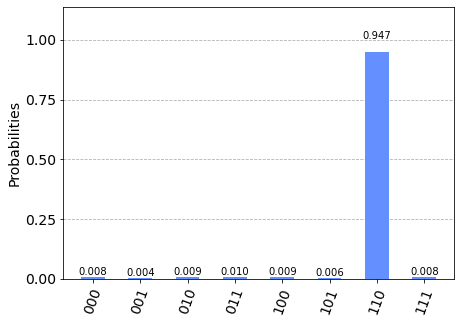

In [3]:
s_above = 0.5
s_below = 0

success_chance = 0.8
bit_accuracy = 2
n = 4 # number of grover qubits. 2**n portfolios will be considered
ws = [np.array([w1,1-w1]) for w1 in np.linspace(0,1,2**n)] # N = 2**n many portfolios

print('(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no.',np.argmax([*map(get_sharpe,ws)]))

# Adjust the grover operator with (classically) obtained oracles at each iteration, 
# until the portfolio with the highest sharpe ratio is found, bzw. its corresponding grover operator
no_of_solutions = 0
while abs(s_above - s_below) > 0.01 or no_of_solutions == 0:
    print('-' * 45)

    s_threshold = (s_above + s_below) / 2
    print(f"s_above: {s_above} , s_threshold: {s_threshold}, s_below: {s_below}")

    solutions = precalculate_solutions(ws,s_threshold)
    print('Winning portfolios: ',solutions, '->',len(solutions),'/', 2**n)


    grov_sol = GroverSolver(solutions)
    grover_op = grov_sol['grover_op']

    no_of_solutions, theta, err = get_count(bit_accuracy,success_chance,grover_op)

    # It gives pi +/- (theoretical) theta bcs we are using -U_s in Grover. The plus/minus comes from the positive/negative phased eigenvalue
    theta = abs(np.pi-theta)
    print('theta: ', theta/np.pi,'pi')

    no_of_solutions = round(no_of_solutions)

    print('%-14s | %-14s' % ('Measured #Sol', 'Error Bound'))
    print('%-14.1f | %-14.2f' % (no_of_solutions, err))

    if no_of_solutions == 0:
        s_above = s_threshold
    else:
        s_below = s_threshold

print('-' * 45,'\n')

# Now that we have found the correct grover op, we can do amplification. 
# We also use the theta, which we have found during Quantum Counting, for determining the number of calls to the oracle.
n = grover_op.num_qubits
t = round(0.5 * (np.pi/theta - 1)) if theta != 0 else 0
print('Number of calls to the oracle:',t)
circ = QuantumCircuit(n)
circ.h(circ.qubits)
for _ in range(t):
    circ.append(grover_op.to_gate(),circ.qubits)

circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)

print('(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no.',int(max(counts, key=counts.get),2))

plot_histogram(counts)


## V1.1

In [4]:
no_of_assets_to_consider = 4

data = pd.read_excel('utils/port_opt_data.xlsx')

returns = data.iloc[1:,1:no_of_assets_to_consider+1].pct_change().dropna()
mu = returns.mean().values[:,None]

cov = returns.cov().values

f_risk = lambda x: np.einsum('...i,...i->...', x.T.dot(cov), x.T)
f_return = lambda x: np.dot(mu.T,x).ravel()

def get_sharpe(w):
    portf_return = f_return(w).item()
    portf_std = np.sqrt(f_risk(w))
    return portf_return/portf_std

def precalculate_solutions(ws,s_threshold): return [i for i,w in enumerate(ws) if get_sharpe(w)>s_threshold]

Number of assets considered:  4
(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no. 7
---------------------------------------------
s_above: 1 , s_threshold: 0.5, s_below: 0
Winning portfolios:  [] -> 0 / 35
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s_above: 0.5 , s_threshold: 0.25, s_below: 0
Winning portfolios:  [2, 3, 7, 8, 21] -> 5 / 35
theta:  0.25 pi
Measured #Sol  | Error Bound   
5.0            | 5.33          
---------------------------------------------
s_above: 0.5 , s_threshold: 0.375, s_below: 0.25
Winning portfolios:  [] -> 0 / 35
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s_above: 0.375 , s_threshold: 0.3125, s_below: 0.25
Winning portfolios:  [] -> 0 / 35
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
--------------------------------------------

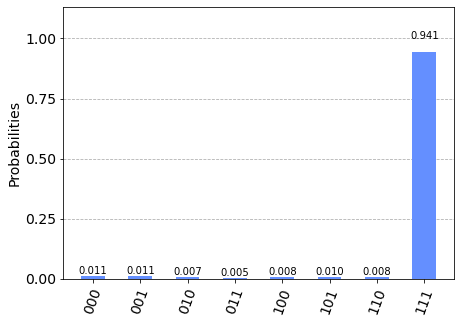

In [5]:
s_above = 1
s_below = 0

success_chance = 0.8
bit_accuracy = 2

incr = 0.25 ; eps = 1e-8
# ws = [np.array([w1,w2,w3,w4,1-w1-w2-w3-w4]).round(6) for w1 in np.arange(0,1+eps,incr) for w2 in np.arange(0,1-w1+eps,incr) for w3 in np.arange(0,1-w2+eps,incr) for w4 in np.arange(0,1-w1-w2-w3+eps,incr)]
ws = [np.array([w1,w2,w3,1-w1-w2-w3]).round(6) for w1 in np.arange(0,1+eps,incr) for w2 in np.arange(0,1-w1+eps,incr) for w3 in np.arange(0,1-w1-w2+eps,incr)]
assert np.all([*map(lambda x: np.all(x>=0),ws)]),np.array(ws)[[*map(lambda x: not np.all(x>=0),ws)]]
n = np.ceil(np.log2(len(ws))) # number of grover qubits.

print('Number of assets considered: ',no_of_assets_to_consider)
print('(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no.',np.argmax([*map(get_sharpe,ws)]))

# Adjust the grover operator with (classically) obtained oracles at each iteration, 
# until the portfolio with the highest sharpe ratio is found, bzw. its corresponding grover operator
no_of_solutions = 0
while abs(s_above - s_below) > 0.01 or no_of_solutions == 0:
    print('-' * 45)

    s_threshold = (s_above + s_below) / 2
    print(f"s_above: {s_above} , s_threshold: {s_threshold}, s_below: {s_below}")

    solutions = precalculate_solutions(ws,s_threshold)
    print('Winning portfolios: ',solutions, '->',len(solutions),'/', len(ws))


    grov_sol = GroverSolver(solutions)
    grover_op = grov_sol['grover_op']

    no_of_solutions, theta, err = get_count(bit_accuracy,success_chance,grover_op)

    # It gives pi +/- (theoretical) theta bcs we are using -U_s in Grover. The plus/minus comes from the positive/negative phased eigenvalue
    theta = abs(np.pi-theta)
    print('theta: ', theta/np.pi,'pi')

    no_of_solutions = round(no_of_solutions)

    print('%-14s | %-14s' % ('Measured #Sol', 'Error Bound'))
    print('%-14.1f | %-14.2f' % (no_of_solutions, err))

    if no_of_solutions == 0:
        s_above = s_threshold
    else:
        s_below = s_threshold

print('-' * 45,'\n')

# Now that we have found the correct grover op, we can do amplification. 
# We also use the theta, which we have found during Quantum Counting, for determining the number of calls to the oracle.
n = grover_op.num_qubits
t = round(0.5 * (np.pi/theta - 1)) if theta != 0 else 0
print('Number of calls to the oracle:',t)
circ = QuantumCircuit(n)
circ.h(circ.qubits)
for _ in range(t):
    circ.append(grover_op.to_gate(),circ.qubits)

circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)

print('(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no.',int(max(counts, key=counts.get),2))

plot_histogram(counts)


# V2

In [5]:
no_of_assets_to_consider = 2 # right now only 2 is supported

data = pd.read_excel('utils/port_opt_data.xlsx')

returns = data.iloc[1:,1:no_of_assets_to_consider+1].pct_change().dropna()
mu = returns.mean().values[:,None]

cov = returns.cov().values

f_risk = lambda x: np.einsum('...i,...i->...', x.T.dot(cov), x.T)
f_return = lambda x: np.dot(mu.T,x).ravel()

def get_sharpe(w):
    portf_return = f_return(w).item()
    portf_std = np.sqrt(f_risk(w))
    return portf_return/portf_std

In [21]:
s_above = 0.25 * 10
s_below = 0

success_chance = 0.8
bit_accuracy = 3
n_state = 2 # number of grover solution qubits. 2**n_state portfolios will be considered
ws = [np.array([w1,1-w1]) for w1 in np.linspace(0,1,2**n_state)] # N = 2**n_state many portfolios

phases = np.array([*map(get_sharpe,ws)]).round(2) * 10 # sharpe ratios of portfolios

print('(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no.',np.argmax(phases))

unitary = np.diag([np.e**(i*1j) for i in phases])
unitary = matrix_to_gate(unitary_mat=unitary,to_gate=True)

t = get_t(bit_accuracy,success_chance)
n = n_state + 2*t + 1 + 1

grover_eigstate = QuantumCircuit(n)
grover_eigstate.x(-1)
grover_eigstate.h(grover_eigstate.qubits[:n_state]+[n-1])
grover_eigstate.x(t+n_state) #eigenstate of phase gate

diffuser = get_diffuser(n_state)

# Adjust the grover operator with (classically) obtained oracles at each iteration, 
# until the portfolio with the highest sharpe ratio is found, bzw. its corresponding grover operator
no_of_solutions = 0
while abs(s_above - s_below) > 1 or no_of_solutions == 0:

    s_threshold = (s_above + s_below) / 2
    s_threshold = round(s_threshold,1)
    assert s_threshold < 2*math.pi
    print(f"s_above: {s_above} , s_threshold: {s_threshold}, s_below: {s_below}")
    
    oracle = QuantumCircuit(n)
    oracle.compose(PhaseEstimatorGate(unitary,t),inplace=True)
    oracle.compose(PhaseEstimatorGate(PhaseGate(s_threshold),t),[*range(t+n_state,2*t+n_state+1)],inplace=True)
    oracle.compose(GreaterThanGate(t),[*range(n_state,t+n_state)]+[*range(t+n_state+1,2*t+n_state+1)]+[n-1],inplace=True)
    oracle.compose(PhaseEstimatorGate(unitary,t).inverse(),inplace=True)
    oracle.compose(PhaseEstimatorGate(PhaseGate(s_threshold),t).inverse(),[*range(t+n_state,2*t+n_state+1)],inplace=True)
    
    grover_op = QuantumCircuit(n)
    grover_op.compose(oracle.to_gate(),grover_op.qubits,inplace=True)
    grover_op.compose(diffuser.to_gate(),grover_op.qubits[:n_state],inplace=True)
    
    print('-' * 45)

    no_of_solutions, theta, err = get_count(bit_accuracy,success_chance,grover_op,grover_eigstate,n=n_state)

    # It gives pi +/- (theoretical) theta bcs we are using -U_s in Grover. The plus/minus comes from the positive/negative phased eigenvalue
    theta = abs(np.pi-theta)
    print('theta: ', theta/np.pi,'pi')

    no_of_solutions = round(no_of_solutions)

    print('%-14s | %-14s' % ('Measured #Sol', 'Error Bound'))
    print('%-14.1f | %-14.2f' % (no_of_solutions, err))

    if no_of_solutions == 0:
        s_above = s_threshold
    else:
        s_below = s_threshold

print('-' * 45,'\n')

(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no. 1
s_above: 2.5 , s_threshold: 1.2, s_below: 0
---------------------------------------------
theta:  0.5 pi
Measured #Sol  | Error Bound   
2.0            | 0.53          
s_above: 2.5 , s_threshold: 1.9, s_below: 1.2
---------------------------------------------
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.03          
s_above: 1.9 , s_threshold: 1.5, s_below: 1.2
---------------------------------------------
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.03          
s_above: 1.5 , s_threshold: 1.4, s_below: 1.2
---------------------------------------------
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.03          
s_above: 1.4 , s_threshold: 1.3, s_below: 1.2
---------------------------------------------
theta:  0.34374999999999994 pi
Measured #Sol  | Error Bound   
1.0            | 0.39          
--------------------------------------------- 

Number of calls to the oracle: 6
(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no. 1
Note that the bits are shown in reverse order on the histogram.


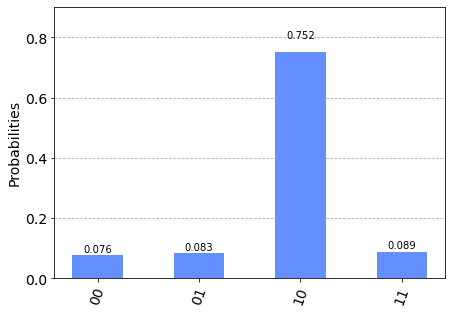

In [27]:
# Now that we have found the correct grover op, we can do amplification. 
# We also use the theta, which we have found during Quantum Counting, for determining the number of calls to the oracle.
n = grover_op.num_qubits
t_grover = round(0.5 * (np.pi/theta - 1)) if theta != 0 else 0
print('Number of calls to the oracle:',t)
circ = QuantumCircuit(n)
circ.compose(grover_eigstate.to_gate(),inplace=True)
for _ in range(t_grover):
    circ.compose(grover_op.to_gate(),inplace=True)

counts = get_counts(circ,circ.qubits[:n_state])

print('(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no.',int(max(counts, key=counts.get)[::-1],2))
print('Note that the bits are shown in reverse order on the histogram.')

plot_histogram(counts)


# V2.1

In [2]:
no_of_assets_to_consider = 2 # right now only 2 is supported

data = pd.read_excel('utils/port_opt_data.xlsx')

returns = data.iloc[1:,1:no_of_assets_to_consider+1].pct_change().dropna()
mu = returns.mean().values[:,None]

cov = returns.cov().values

f_risk = lambda x: np.einsum('...i,...i->...', x.T.dot(cov), x.T)
f_return = lambda x: np.dot(mu.T,x).ravel()

def get_sharpe(w):
    portf_return = f_return(w).item()
    portf_std = np.sqrt(f_risk(w))
    return portf_return/portf_std

In [3]:
####################################
s_above = 0.25
s_below = 0

min_success_chance = 0.99 # desired minimum propagated success chance at the end of quantum counting
nachkommas = 2
n_state = 2 # number of grover solution qubits. 2**n_state portfolios will be considered
####################################


no_of_binary_search_thresholds = (s_above-s_below)/10**-nachkommas
success_chance = (1-min_success_chance)/np.log2(no_of_binary_search_thresholds)
assert success_chance < 0.01 , success_chance
N = 2**n_state
bit_accuracy = math.ceil(np.log2(N)/2 + 1.58)
t = math.ceil(np.log2(10)*nachkommas) + 1 + math.ceil(np.log2(2 + 0.5/0.99)) # for greater-than
n = n_state + 2*t + 1 + 1 # n_state + t (qpe) + 1 (threshold) + t (qpe) + 1 (out)

ws = [np.array([w1,1-w1]) for w1 in np.linspace(0,1,2**n_state)] # N = 2**n_state many portfolios
phases = np.array([*map(get_sharpe,ws)]).round(nachkommas) # sharpe ratios of portfolios
assert np.all(phases<2*np.pi)
print(phases)
print(t,bit_accuracy,n)

[0.11 0.14 0.13 0.1 ]
10 3 24


In [4]:
print('(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no.',np.argmax(phases))

unitary = np.diag([np.e**(i*1j) for i in phases])
unitary = matrix_to_gate(unitary_mat=unitary,to_gate=True)

grover_eigstate = QuantumCircuit(n)
grover_eigstate.x(-1)
grover_eigstate.h(grover_eigstate.qubits[:n_state]+[n-1])
grover_eigstate.x(t+n_state) #eigenstate of phase gate

diffuser = get_diffuser(n_state)

# Adjust the grover operator with (classically) obtained oracles at each iteration, 
# until the portfolio with the highest sharpe ratio is found, bzw. its corresponding grover operator
no_of_solutions = 0
while abs(s_above - s_below) > 1 or no_of_solutions == 0:

    s_threshold = (s_above + s_below) / 2
    s_threshold = round(s_threshold,nachkommas)
    assert s_threshold < 2*math.pi
    print(f"s_above: {s_above} , s_threshold: {s_threshold}, s_below: {s_below}")
    
    oracle = QuantumCircuit(n)
    oracle.compose(PhaseEstimatorGate(unitary,t),inplace=True)
    oracle.compose(PhaseEstimatorGate(PhaseGate(s_threshold),t),[*range(t+n_state,2*t+n_state+1)],inplace=True)
    oracle.compose(GreaterThanGate(t),[*range(n_state,t+n_state)]+[*range(t+n_state+1,2*t+n_state+1)]+[n-1],inplace=True)
    oracle.compose(PhaseEstimatorGate(unitary,t).inverse(),inplace=True)
    oracle.compose(PhaseEstimatorGate(PhaseGate(s_threshold),t).inverse(),[*range(t+n_state,2*t+n_state+1)],inplace=True)
    
    grover_op = QuantumCircuit(n)
    grover_op.compose(oracle.to_gate(),grover_op.qubits,inplace=True)
    grover_op.compose(diffuser.to_gate(),grover_op.qubits[:n_state],inplace=True)
    
    print('-' * 45)

    no_of_solutions, theta, err = get_count(bit_accuracy,success_chance,grover_op,grover_eigstate,n=n_state)

    no_of_solutions = round(no_of_solutions)

    print('%-14s | %-14s' % ('Measured #Sol', 'Error Bound'))
    print('%-14.1f | %-14.2f' % (no_of_solutions, err))

    if no_of_solutions == 0:
        s_above = s_threshold
    else:
        s_below = s_threshold

print('-' * 45,'\n')

(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no. 1
s_above: 0.25 , s_threshold: 0.12, s_below: 0
---------------------------------------------
t:  5 grover_op.num_qubits:  24


Number of calls to the oracle: 6
(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no. 1
Note that the bits are shown in reverse order on the histogram.


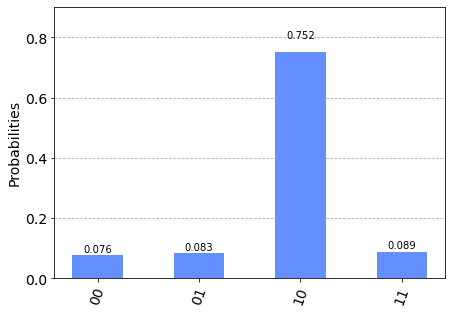

In [ ]:
# Now that we have found the correct grover op, we can do amplification. 
# We also use the theta, which we have found during Quantum Counting, for determining the number of calls to the oracle.
n = grover_op.num_qubits
theta = np.arcsin(1/np.sqrt(N))
assert theta != 0 
t_grover = round(0.5 * (np.pi/theta - 1))
print('Number of calls to the oracle:',t)
circ = QuantumCircuit(n)
circ.compose(grover_eigstate.to_gate(),inplace=True)
for _ in range(t_grover):
    circ.compose(grover_op.to_gate(),inplace=True)

counts = get_counts(circ,circ.qubits[:n_state])

print('(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no.',int(max(counts, key=counts.get)[::-1],2))
print('Note that the bits are shown in reverse order on the histogram.')

plot_histogram(counts)
